In [399]:
import pythtb as tb
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

class Orbital(object):
    """ Orbital object with a onsite energy """
    def __init__(self, onsite, label):
        """
        Initialize an instance of orbital
        
        :type  onsite: float
        :param onsite: The onsite energy of the orbital
        
        :type  label: string
        :param label: The name of the orbital (examples: s,p,d,f)
        """
        self.label = label
        self.onsite = onsite

    def __repr__(self):
        """ Representation of the orbital object """
        return "{} with onsite {}".format(self.label, self.onsite)
        
class Atom(object):
    """ Atom object hosting orbitals """
    def __init__(self, position, number):
        """ Initialize an instance of atom
        
        :type  position: ndarray, list, tuple
        :param position: The onsite energy of the orbital
        
        :type  number: int
        :param number: The atomic number of the atom (Z)
        """
        position = np.asarray(position)
        self.number = number
        self.position = position
        self.orbitals = []
    
    def add_orbital(self, orbital):
        """ Add an orbital to the hosting atom
        :type  orbital: orbital object
        :param orbital: an orbital in the atom
        """
        self.orbitals.append(orbital)
        
    def number_of_orbitals(self):
        """ Returns the number of orbitals in the atom 
        :returns: the number of orbitals in the atom
        """
        return len(self.orbitals)     

    
    def __repr__(self):
        """ Representation of the Atom object """

        return "Atom with Z={} at {}".format(self.number, self.position)
    
class Crystal:
    
    def __init__(self, lattice):
        """ Initialize an instance of crystal with lattice hosting atom objects
        
        :type  lattice: ndarray
        :param lattice: a 3x3 array with lattice parameters [a,b,c]
        """
        self.lattice = lattice
        self.atoms = []
        
    def add_atom(self,atom):
        """ Add an atom object to the crystal
        :type  atom: atom object
        :param atom: the instance of atom to be placed in the crystal
        """
        existing = False
        for existing_atom in self.atoms:
            if np.all(atom.position == existing_atom.position):
                existing = True
        if not existing:
            self.atoms.append(atom)
            return "Placed atom at {}".format(atom.position)
        else:
            raise Warning("An atom is already at").format(atom.position)
            
    def __repr__(self):
        """ Representation of the crystal object """
        string = "Lattice:\n{}\nAtoms:\n".format(self.lattice)
        
        for i, atom in enumerate(self.atoms):
            string += "{}: {}\n".format(i,atom)
        return string

    
class TransitionMatrix:
    """ A matrix containing all hopping parameters between to atoms"""
    def __init__(self, initial_atom, final_atom, equivalent_final_cells=[[0, 0, 0]]):
        """ Create an instance of TransitionMatrix based on an initial and final atom
        
        :type  initial_atom: atom object
        :param initial_atom: the initial atom in the transition matrix
        
        :type  final_atom: atom object
        :param final_atom: the final atom in the transition matrix
        
        :type  equivalent_final_cells: list
        :param equivalent_final_cells: list of int-coordinates to neighbouring cells
        """
        
        self.set_transitions( 
            np.zeros((
                initial_atom.number_of_orbitals(),
                final_atom.number_of_orbitals())
            ) 
        )
        
        self.set_equivalent_final_cells(equivalent_final_cells)
        
        
        if initial_atom == final_atom:
            self.label = "Onsite element at {}\n".format(initial_atom)
        else:
            self.label = "From {} to {}\n".format(initial_atom,final_atom)
            
    def set_transitions(self, transition_matrix):
        """ Replace the full transition matrix
        
        :type  transition_matrix: ndarray
        :param transition_matrix: the new transition matrix
        """
        self.transitions = transition_matrix
        
    def set_equivalent_final_cells(self, equivalent_final_cells):
        """ set the list of equivalent final cells
        
        :type  equivalent_final_cells: list
        :param equivalent_final_cells: the new list of int-coordinates to neighbouring cells
        """
        self.equivalent_final_cells = equivalent_final_cells
            
    def __getitem__(self, index):
        """ Get the hopping parameter by the index of initial and final orbital [i][f]"""
        return self.transitions[index]
    
    def __repr__(self):
        """ Represent the transition matrix object"""
        string = self.label+"M=\n{}\nEquivalent cells: {}".format(self.transitions, self.equivalent_final_cells)
        return string
    
    
class AtomMatrix:
    """ A matrix containing all transition matrices between atoms """
    def __init__(self, crystal):
        """ Create instance of atom matrix
        :type  crystal: crystal object
        :param crystal: a crystal containing atoms
        """
        self.atom_matrix = []
        
        for i,initial_atom in enumerate(crystal.atoms):
            atom_matrix_row = []    

            for final_atom in crystal.atoms:    
                transition_matrix = TransitionMatrix(initial_atom, final_atom)

                if initial_atom == final_atom:
                    for i, orbital in enumerate(initial_atom.orbitals):
                        transition_matrix[i][i] = orbital.onsite
                        
                atom_matrix_row.append(transition_matrix)
                
            self.atom_matrix.append(atom_matrix_row)

    def __getitem__(self, index):
        """ Get a transition matrix by the index of initial and final atom [i][f]"""
        return self.atom_matrix[index]
                
    def __repr__(self):
        """ Representation of the atom matrix object"""
        string = "Atom matrix:\n"
        for i, atom_matrix_row in enumerate(self.atom_matrix):
            for f, transition_matrix in enumerate(atom_matrix_row[i:]):
                string += "{}\n\n".format(transition_matrix)
        return string
    
    
class WursiteSP3(AtomMatrix):
    """ A special case of AtomMatrix designed for sp3 wursite structure"""
    def __init__(self, crystal):
        """ Create an instance of the wursite sp3 atom matrix"""
        AtomMatrix.__init__(self, crystal)
        self._crystal = crystal
        
    def get_hopping_parameters(self):
        """ Get a list of all hopping parameters in the model"""
        return [self.Vss, self.Vxx, self.Vxy, self.Vsapc, self.Vpasc ]
        
        
    def set_hopping_parameters(self, Vss, Vxx, Vxy, Vsapc, Vpasc):
        """ Set all hopping parameters in the model
        
        :type  Vss: float
        :param Vss: The hopping parameter from s to s
        
        :type  Vxx: float
        :param Vxx: The hopping parameter from px of the anion to px of the cation
        
        :type  Vxy: float
        :param Vxy: The hopping parameter from px of the anion to py of the cation
        
        :type  Vsapc: float
        :param Vsapc: The hopping parameter from s of the anion to p of the cation
        
        :type  Vpasc: float
        :param Vpasc: The hopping parameter from p of the anion to s of the cation
        """
        self.Vss = Vss
        self.Vxx = Vxx
        self.Vxy = Vxy
        self.Vsapc = Vsapc
        self.Vpasc = Vpasc
        
        
        self.Uss = 0.25*Vss
        self.Uzz = 0.25*(Vxx+2*Vxy)
        self.Uxx = 0.25*(Vxx-Vxy)

        self.Usz = -0.25*np.sqrt(3)*Vsapc
        self.Uzs =  0.25*np.sqrt(3)*Vpasc
        
        
        """###############    What to do with these?   ##################"""
        self.Usx =   0.0
        self.Uxs =   0.0
        self.Uzx =   0.0
        self.Uxz =   0.0
        self.Uyy =   0.0
        """##############################################################"""
        

        positions = np.array([
            [0.0, 0.0, 0.0],
            [2/3, 1/3, 1/2],
            [2/3, 1/3, 1/8],
            [0.0, 0.0, 5/8]])
        
        for i,initial_atom in enumerate(self._crystal.atoms):
            for f,final_atom in enumerate(self._crystal.atoms):
                print("From {} to {}".format(initial_atom,final_atom))
                if np.all(initial_atom.position == positions[0]):
                    if np.all(final_atom.position == positions[2]):
                        self.atom_matrix[i][f].set_transitions(self._M02())   
                        self.atom_matrix[i][f].set_equivalent_final_cells([[0, 0, 0], [-1, 0, 0], [-1, -1, 0]])
                    
                    elif np.all(final_atom.position == positions[3]):
                        self.atom_matrix[i][f].set_transitions(self._M03())
                        self.atom_matrix[i][f].set_equivalent_final_cells([[0, 0, -1]])
                        
                        
                elif np.all(initial_atom.position == positions[1]):
                    
                    if np.all(final_atom.position == positions[2]):
                        self.atom_matrix[i][f].set_transitions(self._M03())                        
                        self.atom_matrix[i][f].set_equivalent_final_cells([[0, 0, 0]])   
    
                    elif np.all(final_atom.position == positions[3]):
                        self.atom_matrix[i][f].set_transitions(self._M13())
                        self.atom_matrix[i][f].set_equivalent_final_cells([[0, 0, 0], [1, 1, 0], [1, 0, 0]])
                        


    def _M03(self):
        """ The M14 transition matrix designed by Kobayashi et Al."""
        transition_matrix = np.array([
            [self.Uss, self.Usz,      0.0,      0.0],
            [self.Uzs, self.Uzz,      0.0,      0.0],
            [     0.0,      0.0, self.Uxx,      0.0],
            [     0.0,      0.0,      0.0, self.Uxx]])

        return transition_matrix
    
    def _M02(self):
        """ The M13 transition matrix designed by Kobayashi et Al."""
        transition_matrix = np.array([
            [               self.Uss,                self.Usz,                            self.Usx,             (np.sqrt(3)/2)*self.Usx],
            [               self.Uzs,                self.Uzz,                            self.Uzx,             (np.sqrt(3)/2)*self.Uzx],
            [               self.Uxs,                self.Uxz,  self.Uxx+(3/4)*(self.Uxx+self.Uyy), (-np.sqrt(3)/4)*(self.Uxx-self.Uyy)],
            [(np.sqrt(3)/2)*self.Uxs, (np.sqrt(3)/2)*self.Uxz, (-np.sqrt(3)/4)*(self.Uxx-self.Uyy),  self.Uyy+(3/4)*(self.Uxx+self.Uyy)]])

        return transition_matrix

    def _M13(self):
        """ The M24 transition matrix designed by Kobayashi et Al."""
        transition_matrix = np.array([
            [self.Uss, self.Usz, -self.Usx, (-np.sqrt(3)/2)*self.Usx],
            [self.Uzs, self.Uzz, -self.Uzx, (-np.sqrt(3)/2)*self.Uzx],
            [-self.Uxs, -self.Uxz, self.Uxx+(3/4)*(self.Uxx+self.Uyy), (-np.sqrt(3)/4)*(self.Uxx-self.Uyy)],
            [(-np.sqrt(3)/2)*self.Uxs, (-np.sqrt(3)/2)*self.Uxz, (-np.sqrt(3)/4)*(self.Uxx-self.Uyy), self.Uyy+(3/4)*(self.Uxx+self.Uyy)]])

        return transition_matrix
    
class TightBinding:
    """ Tight binding class constructed around the pythTB package """
    def __init__(self, crystal):
        """ Create instance of the Tight binding model 
        
        :type  crystal: crystal object
        :param crystal: a crystal object containing atoms
        """
        self.crystal = crystal
        
        self.atom_matrix = WursiteSP3(self.crystal)
        
        self._orbital_positons = []
        for atom in crystal.atoms:
            for orbital in atom.orbitals:
                self._orbital_positons.append(atom.position)
        
        
        self.model = tb.tb_model(3,3,self.crystal.lattice, self._orbital_positons)
        
    def set_hopping_parameters(self, *args):
        """ Set the hopping parameters in the transition matrices by a list
        
        :param args: passes all arguments to the atom matrix
        """
        self.atom_matrix.set_hopping_parameters(*args)
        self.update()

    def update(self):
        """ update the TB-model from the atom matrix """
        index_initial = 0
        for i, initial_atom in enumerate(self.crystal.atoms):
            index_final = index_initial
            for f, final_atom in enumerate(self.crystal.atoms[i:]):
                f = f+i

                for io, initial_orbital in enumerate(initial_atom.orbitals):
                    for fo, final_orbital in enumerate(initial_atom.orbitals):

                    # Set onsite elements
                        if initial_atom == final_atom:
                            if initial_orbital == final_orbital:
                                self.model.set_onsite(self.atom_matrix[i][f][io][fo], ind_i=(index_initial+io), mode='reset')
        
                    # Set hopping parameters
                        else:
                            for final_cell in self.atom_matrix[i][f].equivalent_final_cells:
                                self.model.set_hop(self.atom_matrix[i][f][io][fo], ind_i=(index_initial+io), ind_j=(index_final+fo), ind_R=final_cell, mode='reset')

                
                index_final += final_atom.number_of_orbitals()    
            index_initial += initial_atom.number_of_orbitals()
    def display_pythtb(self):
        """ Displat the info from pythTB """
        self.model.display()
        
    def calculate(self, k_grid, eig_vectors = False):
        """ Calculate band energies for the given k-points 
        
        :type  k_grid: ndarray, list
        :param k_grid: an array/list of 3D k-points
        
        :type  eig_vectors: bool
        :param eig_vectors: if eigen vectors are returned
        """
        return self.model.solve_all(k_grid,eig_vectors=eig_vectors)

    
    def bandstructure(self, ylim=(None,None), color=None, ax=None):
        """ Plot a representation of the band structure
        
        :type  ylim: tuple, list
        :param ylim: lower and upper limit of y-values (ymin,ymax)
        """

        """ seekpath automatic lines"""
        #path = sp.get_explicit_k_path((lattice, positions, numbers), False, recipe="hpkot", threshold=1e-5,reference_distance=1)
        #expath = path['explicit_kpoints_abs'][:5]
        #labels = path['explicit_kpoints_labels'][:5]

        """ manual lines"""
        path=[[0.0,0.0,0.5],[0.5,0.0,0.5],[0.5,0,0.0],[0.0,0.0,0.0],[0,0,0.5],[2./3.,1./3.,0.5],[2./3.,1./3.,0.0],[0,0,0]]
        label=(r'$A $',      r'$L$',       r'$M$',   r'$\Gamma$', r'$A $', r'$H$',  r'$K$',r'$\Gamma $')

        
        # call function k_path to construct the actual path
        (k_vec,k_dist,k_node)=self.model.k_path(path,301,report=False)

        evals =self.model.solve_all(k_vec)
        
        fig = None
        if not ax:
            fig, ax = plt.subplots(figsize=(8,6))
            fig.tight_layout()

            ax.set_title("Bandstructure for Zno based on Kobayashi")
            ax.set_ylabel("Band energy")

            # specify horizontal axis details
            ax.set_xlim([0,k_node[-1]])
            # put tickmarks and labels at node positions
            ax.set_xticks(k_node)
            ax.set_xticklabels(label)
            # add vertical lines at node positions

            for n in range(len(k_node)):
                if label[n] == r'$\Gamma$':
                    ax.axvline(x=k_node[n],linewidth=1, color='k')
                else:
                    ax.axvline(x=k_node[n],linewidth=0.5, color='k')
    
        for band in evals:
            ax.plot(k_dist, band, color=color)

        if not fig:
            return ax
        else:
            ax.set_ylim(ylim)
            return ax, fig

    def __repr__(self):
        return "Tight binding model for: \n \n {} \n {}".format(self.crystal, self.atom_matrix)
    
class Oxygen(Atom):
    """ A special case of Atom designed for Oxygen"""
    def __init__(self, position):
        Atom.__init__(self, position, 8)
        self.add_orbital(Orbital(-19.046, "S"))
        self.add_orbital(Orbital(  4.142, "Pz"))
        self.add_orbital(Orbital(  4.142, "Px"))
        self.add_orbital(Orbital(  4.142, "Py"))
    
    def __repr__(self):
        return "Oxygen at {}".format(self.position)
    
class Zinc(Atom):
    """ A special case of Atom designed for Zinc"""
    def __init__(self, position):
        
        Atom.__init__(self, position, 30)
        self.add_orbital(Orbital(  1.805, "S"))
        self.add_orbital(Orbital( 12.368, "Pz"))
        self.add_orbital(Orbital( 12.368, "Px"))
        self.add_orbital(Orbital( 12.368, "Py"))
        
    def __repr__(self):
        return "Zinc at {}".format(self.position)
    

class Gallium(Atom):
    """ A special case of Atom designed for Gallium"""
    def __init__(self, position):
        
        Atom.__init__(self, position, 30)
        self.add_orbital(Orbital(  1.438, "S"))
        self.add_orbital(Orbital( 10.896, "Pz"))
        self.add_orbital(Orbital( 10.896, "Px"))
        self.add_orbital(Orbital( 10.896, "Py"))
    
    def __repr__(self):
        return "Gallium at {}".format(self.position)
    
class Nitrogen(Atom):
    """ A special case of Atom designed for Nitrogen"""
    def __init__(self, position):
        
        Atom.__init__(self, position, 30)
        self.add_orbital(Orbital(-11.012, "S"))
        self.add_orbital(Orbital(  0.005, "Pz"))
        self.add_orbital(Orbital(  0.005, "Px"))
        self.add_orbital(Orbital(  0.005, "Py"))
        
    def __repr__(self):
        return "Nitrogen at {}".format(self.position)   

In [400]:
class TbFitter():
    mu = 0
    T = 1
    def __init__(self, model, fitting_k, fitting_E, band_range=(0,-1), monitor=False, tolerance=None):
        self.model = model
        self.monitor = monitor
        self.fitting_k = fitting_k
        self.fitting_E = fitting_E
        self.tolerance = tolerance
        self.band_range = band_range
        
    def fit(self):
        initial_args = self.model.atom_matrix.get_hopping_parameters()
        
        return minimize(self.fit_function, initial_args, tol=self.tolerance)
        
    def fit_function(self, args):
        Vss, Vxx, Vxy, Vsapc, Vpasc = args
        self.model.set_hopping_parameters(Vss, Vxx, Vxy, Vsapc, Vpasc)
        E =self.model.calculate(self.fitting_k)[self.band_range[0]:self.band_range[1]]
    
        

        diff=self.fitting_E-E

        diff=abs(diff)**2
        
        val=sum((diff*self.weightfun(self.fitting_E,E)).ravel())
        
        if self.monitor:
            print(val)
            
        self.lastval=val
        self.weightsum=sum((self.weightfun(self.fitting_E,E)).ravel())
        return val
    
    def weightfun(self,E1,E2):
        w1=1./np.cosh((E1-self.mu)/self.T)**2/self.T/8
        w2=1./np.cosh((E2-self.mu)/self.T)**2/self.T/8
        return w1+w2

In [401]:
ZnO = Crystal(lattice = np.array([
        [ np.sqrt(3)/2, -0.5, 0.0],
        [ 0.0, 1.0,  0.0],
        [ 0.0, 0.0, 1.65]])*3.25)

ZnO.add_atom(Oxygen([0,0,0]))
ZnO.add_atom(Oxygen([2/3, 1/3, 1/2]))
ZnO.add_atom(Zinc([2/3, 1/3, 1/8]))
ZnO.add_atom(Zinc([0.0, 0.0, 5/8]))


ZnO_tb = TightBinding(ZnO)

Vss   = -6.043
Vxx   =  7.157
Vxy   = 10.578
Vsapc =  4.703
Vpasc =  8.634

ZnO_tb.set_hopping_parameters(Vss, Vxx, Vxy, Vsapc, Vpasc)

From Oxygen at [0 0 0] to Oxygen at [0 0 0]
From Oxygen at [0 0 0] to Oxygen at [ 0.66666667  0.33333333  0.5       ]
From Oxygen at [0 0 0] to Zinc at [ 0.66666667  0.33333333  0.125     ]
From Oxygen at [0 0 0] to Zinc at [ 0.     0.     0.625]
From Oxygen at [ 0.66666667  0.33333333  0.5       ] to Oxygen at [0 0 0]
From Oxygen at [ 0.66666667  0.33333333  0.5       ] to Oxygen at [ 0.66666667  0.33333333  0.5       ]
From Oxygen at [ 0.66666667  0.33333333  0.5       ] to Zinc at [ 0.66666667  0.33333333  0.125     ]
From Oxygen at [ 0.66666667  0.33333333  0.5       ] to Zinc at [ 0.     0.     0.625]
From Zinc at [ 0.66666667  0.33333333  0.125     ] to Oxygen at [0 0 0]
From Zinc at [ 0.66666667  0.33333333  0.125     ] to Oxygen at [ 0.66666667  0.33333333  0.5       ]
From Zinc at [ 0.66666667  0.33333333  0.125     ] to Zinc at [ 0.66666667  0.33333333  0.125     ]
From Zinc at [ 0.66666667  0.33333333  0.125     ] to Zinc at [ 0.     0.     0.625]
From Zinc at [ 0.     0.   

In [402]:
ZnO_tb.display_pythtb()

---------------------------------------
report of tight-binding model
---------------------------------------
k-space dimension           = 3
r-space dimension           = 3
number of spin components   = 1
periodic directions         = [0, 1, 2]
number of orbitals          = 16
number of electronic states = 16
lattice vectors:
 #  0  ===>  [  2.8146 ,  -1.625 ,     0.0 ]
 #  1  ===>  [     0.0 ,    3.25 ,     0.0 ]
 #  2  ===>  [     0.0 ,     0.0 ,  5.3625 ]
positions of orbitals:
 #  0  ===>  [     0.0 ,     0.0 ,     0.0 ]
 #  1  ===>  [     0.0 ,     0.0 ,     0.0 ]
 #  2  ===>  [     0.0 ,     0.0 ,     0.0 ]
 #  3  ===>  [     0.0 ,     0.0 ,     0.0 ]
 #  4  ===>  [  0.6667 ,  0.3333 ,     0.5 ]
 #  5  ===>  [  0.6667 ,  0.3333 ,     0.5 ]
 #  6  ===>  [  0.6667 ,  0.3333 ,     0.5 ]
 #  7  ===>  [  0.6667 ,  0.3333 ,     0.5 ]
 #  8  ===>  [  0.6667 ,  0.3333 ,   0.125 ]
 #  9  ===>  [  0.6667 ,  0.3333 ,   0.125 ]
 # 10  ===>  [  0.6667 ,  0.3333 ,   0.125 ]
 # 11  ===>  [  0.

|  pos(  2 )  - pos(  4 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  2 )  - pos(  5 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  2 )  - pos(  6 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  2 )  - pos(  7 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  3 )  - pos(  4 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  3 )  - pos(  5 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  3 )  - pos(  6 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  3 )  - pos(  7 + [  0 ,  0 ,  0 ] ) |  =    3.2726
|  pos(  0 )  - pos(  8 + [  0 ,  0 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos(  8 + [ -1 ,  0 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos(  8 + [ -1 , -1 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos(  9 + [  0 ,  0 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos(  9 + [ -1 ,  0 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos(  9 + [ -1 , -1 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos( 10 + [  0 ,  0 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos( 10 + [ -1 ,  0 ,  0 ] ) |  =    1.9925
|  pos(  0 )  - pos( 10 + [ -1 , -1 ,  0

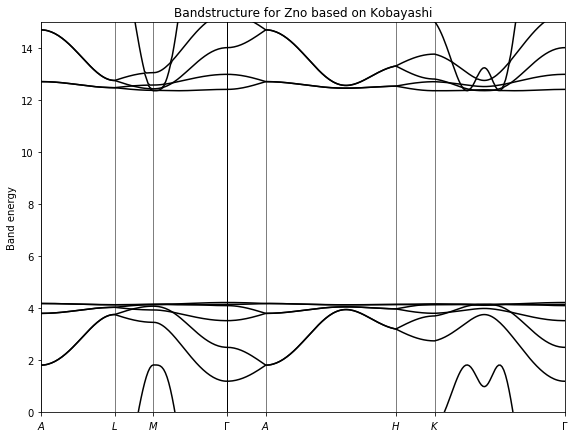

In [403]:
ax, fig = ZnO_tb.bandstructure(color="black",ylim=(0,15))
plt.show()

In [296]:
fitting_k=np.array([
    [  0.5,   0.0, 0.5],
    [  0.0,   0.0, 0.0],
    [  0.0,   0.0, 0.5],
    [2./3., 1./3., 0.5],
    [2./3., 1./3., 0.0]])

fitting_E = np.array([
    [-5.78, -5.85, -3.63, -5.82, -5.63], #2
    [-5.78, -1.52, -3.63, -5.82, -5.63], #3
    [-2.44, -1.52, -0.79, -3.13, -3.90], #4
    [-2.44,  0.00, -0.79, -3.13, -2.63], #5
    [-2.34,  0.00, -0.79, -2.30, -2.63], #6
    [-2.34,  0.00, -0.79, -2.30, -2.30], #7                 
    [ 9.05,  3.30,  6.11,  9.74, 10.55], #8                 
])



fitting_k = fitting_k[1:3]


fitting_E = fitting_E[:,1:3]

band_range = (2,9)

In [297]:
print(fitting_E)
print(ZnO_tb.calculate(fitting_k)[2:9])


[[-5.85 -3.63]
 [-1.52 -3.63]
 [-1.52 -0.79]
 [ 0.   -0.79]
 [ 0.   -0.79]
 [ 0.   -0.79]
 [ 3.3   6.11]]
[[-12.16684842 -10.19506135]
 [ -5.8684175  -10.19506135]
 [  3.07742156   3.32487454]
 [  3.58542232   3.32487454]
 [  3.943975     4.0342438 ]
 [  4.12648582   4.0342438 ]
 [  5.85798123   6.04557073]]


In [289]:
ZnO_fitter = TbFitter(model=ZnO_tb, fitting_k=fitting_k, fitting_E=fitting_E, band_range=band_range, monitor=False)